### Load BNC

In [ ]:
import datasets

def load_bnc():
    from nltk.corpus.reader import bnc
    bnc_reader = bnc.BNCCorpusReader(root='./data/BNC/Texts/', fileids=r'[A-K]/\w*/\w*\.xml')
    return bnc_reader #.tagged_sents()


### Load Concreteness ratings

In [9]:
CONCRETENESS_RATINGS_PATH = '../data/brysbaert/Concreteness_ratings_Brysbaert_et_al_BRM.txt'


def load_ratings(path=CONCRETENESS_RATINGS_PATH, override=False):
    import csv
    #items = []
    ratings_dict = {}

    with open(CONCRETENESS_RATINGS_PATH, mode='r') as csv_file:
        csv_reader = csv.DictReader(csv_file, delimiter='\t')
        line_count = 0
        for row in csv_reader:
            word = row["Word"]
            rating = row["Conc.M"]
            if float(row["Bigram"]) == 1:
                bigram = True
            else:
                bigram = False
            item = {"word": word,
                    "concreteness": float(rating),
                    "bigram": bigram,
                   }
            #items.append(item)
            ratings_dict[word] = item
            line_count+=1
    print("processed %s words from Brysbaert dataset" % line_count)
    
    unigrams = 0
    bigrams = 0
    for x in ratings_dict.values():
        if x["bigram"] == True:
               bigrams +=1
        else:
               unigrams +=1
    print("# unigrams: %s" % unigrams)
    print("# bigrams: %s" % bigrams)
    
    
    return ratings_dict

ratings_dict = load_ratings()

ratings["fire"]

# TODO what is the relationship between num word pieces and concreteness rating? so magnanimous is rated lower (more abstract) than magnanimously. Are people adding abstractness for extra morphemes?

processed 39954 words from Brysbaert dataset
# unigrams: 37058
# bigrams: 2896


{'word': 'fire', 'concreteness': 4.68, 'bigram': False}

### Get token contexts for BNC words

In [ ]:
def randomly(seq):
    import random
    shuffled = list(seq)
    random.shuffle(shuffled)
    return list(shuffled)


def current_word(index, sentence):
    # the first item in the BNC tuple is the word string
    return sentence[index][0]

def next_word(index, sentence):
    # if we haven't reached the last word, return next word
    # the first item in the BNC tuple is the word string
    if index < len(sentence) - 1:
        return sentence[index+1][0]
    else:
        return None


def is_biword(current, nextt, bigrams):
    if nextt == None:
        return False
    biword = current + " " + nextt
    # if the phrase is in the Brys. dictionary, flag it as a biword
    if bigrams.get(biword) != None:
        return True
    else:
        return False

def collect_bigram(sentence):
    return None

def collect_bnc_examples(ratings_dict, max_num_examples=50, override=False):
    import os.path
    import csv
    
    #pathname = './data/bnc_words_with_context_tokens.csv'
    
    # do we already have the data collected?
    if os.path.isfile(pathname) and override==False:
        print("data already exist at %s" % pathname)
        return
    
    else:    
        bnc_reader = load_bnc()
        corpus = bnc_reader.tagged_sents(strip_space=True)
        corpus_length = len(corpus)
        print("# Sentences in BNC corpus: %s" % corpus_length)

        
        #with open('./data/bnc_words_with_context_tokens.csv', mode='w') as outfile:
            writer = csv.writer(outfile, delimiter='\t', quoting=csv.QUOTE_NONNUMERIC)
            
            # create data structures for keeping tabs on how many tokens we have collected
            unigrams = {}
            bigrams = {}
            for x in ratings.values():
                word = x["word"]
                if x["bigram"] == True:
                    bigrams[word]=max_num_examples
                else:
                    unigrams[word]=max_num_examples
                    
            
            # come up with a random order in which to traverse the BNC
            randomized_indexes = randomly([x for x in range(corpus_length-1)])
            
            """"
            Iterate through the corpus, looking at words one by one, and 
            keep iterating as long as we still have tokens to collect
            """
            while (bigrams or unigrams) and randomized_indexes:
                corpus_index = randomized_indexes.pop()
                sentence = corpus[corpus_index]
                i = 0
               
                # check if we should collect sentence as a token for some brysbaert unigram or bigram
                for word_tuple in sentence:
                
                    current_token = current_word(i, sentence)
                    next_token = next_word(i, sentence)
                    
                    # first check if its a multi-word expression
                    bigram = is_biword(current_token, next_token, bigrams)
                    
                    # collect bigram token
                    if bigram:
                        biword = current_token + " " + next_token
                        tag = ""
                        string = ' '.join([w[0] for w in sentence])
                        #entry = "%s\t%s\t%s\t%s\n" % (biword, string, tag, corpus_index)                            
                        #disk.write(entry)
                        writer.writerow([biword, string, tag, corpus_index])
                        bigrams[biword] -= 1
                        if bigrams[biword] == 0:
                            del bigrams[biword]
                
                    #otherwise check if it should be collected as a unigram and collect
                    else:
                        word = word_tuple[0]
                        tag = word_tuple[1]
                        string = ' '.join([w[0] for w in sentence])
                        
                        token_count = unigrams.get(word) 
                        if token_count != None:
                            #entry = "%s\t%s\t%s\t%s\n" % (word, string, tag, corpus_index)
                            #disk.write(entry)
                            writer.writerow([word, string, tag, corpus_index])
                            unigrams[word] -=1
                            if unigrams[word]==0:
                                del unigrams[word]
                        
                    i+=1




#collect_bnc_examples(ratings, override = True)

### Get some stats on the data

In [ ]:
# What's the average number of examples for each word?
#os.system("awk 'BEGIN {FS=OFS="\t"} NR > 0 {a[$1]+=1} END {for (i in a) {print i, a[i]}}' bnc_words_with_context_tokens.txt | sort -n >> bnc_counts.txt")

50 tokens for 19370 words
Over 20 tokens for 24086 words
Over 10 tokens for 27235 words
Less than 20 tokens for 11247 words
                   word  count  concreteness
0                   sat     49          3.88
1                  back     49          4.33
2                    in     49          3.00
3                   her     49          3.00
4                 chair     49          4.58
...                 ...    ...           ...
27230      orchestrator     10          4.03
27231  internationality     12          2.28
27232             byway     10          3.32
27233           lowlife     10          3.27
27234         worldview     11          2.31

[27235 rows x 3 columns]
Index(['word', 'count', 'concreteness'], dtype='object')


[Text(0.5, 0, '')]

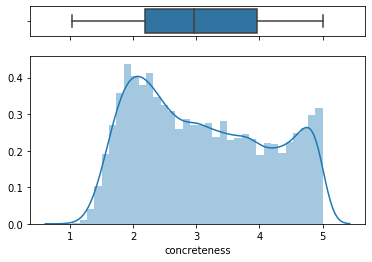

In [16]:
import csv
import matplotlib
import seaborn as sns, pandas as pd
import matplotlib.pyplot as plt

#############
# How many do we keep if we want 20 examples minimum? 10?
##############
with open('../../abstract_bert/data/bnc_words_with_context_tokens.csv', mode="r") as infile:
    reader = csv.reader(infile, delimiter="\t")
    #token_counts = {row[0]:int(row[1]) for row in reader}
    token_counts = {}
    for row in reader:
        word = row[0]
        if word in token_counts:
            token_counts[word] += 1
        else:
            token_counts[word] = 0
    
    fifty = [(x, y, ratings_dict[x]) for (x,y) in token_counts.items() if y >=49]
    over_twenty = {x: y for (x,y) in token_counts.items() if y >=20}
    less_than_twenty = {x: y for (x,y) in token_counts.items() if y <20}
    over_ten = [[x, y, ratings[x]["concreteness"]] for (x,y) in token_counts.items() if y >=10]
    print("50 tokens for %s words" %len(fifty))
    print("Over 20 tokens for %s words" %len(over_twenty))
    print("Over 10 tokens for %s words" %len(over_ten))
    print("Less than 20 tokens for %s words" %len(less_than_twenty))

################
# What's the relationship betweeen abstractness and frequency in the corpus? We want this to be relatively even, I think....
################

df = pd.DataFrame.from_records(over_ten, columns=["word", "count", "concreteness"])
print(df)
print(df.columns)

# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

# Add a graph in each part
sns.boxplot(df["concreteness"], ax=ax_box)
sns.distplot(df["concreteness"], ax=ax_hist)

 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')

#### Compare to the distribution of ratings in the entire Brysbaert data set

                  word  concreteness
0          roadsweeper          4.85
1          traindriver          4.54
2                 tush          4.45
3            hairdress          3.93
4        pharmaceutics          3.77
...                ...           ...
39949         unenvied          1.21
39950     agnostically          1.20
39951  conceptualistic          1.18
39952  conventionalism          1.18
39953    essentialness          1.04

[39954 rows x 2 columns]
Index(['word', 'concreteness'], dtype='object')


[Text(0.5, 0, '')]

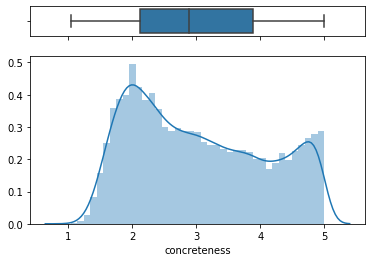

In [13]:
df = pd.DataFrame.from_records(list(ratings.values()), columns=["word", "concreteness"])
print(df)
print(df.columns)

# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})


# Add a graph in each part
sns.boxplot(df["concreteness"], ax=ax_box)
sns.distplot(df["concreteness"], ax=ax_hist)

 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')

In [ ]:
import os
import csv

ALLWORDS_DIR = './data/brysbaert_word_data'

# you already have tokens collected for each word in simlex and wordsim
# now these tokens ought to be sorted into their own files

# ensure that there is a word_data directory to store in our words
# you have to delete it first with rm -rf if we are reloading
os.mkdir(ALLWORDS_DIR)


# create files for each word we care about
for word in ratings.keys():
    word_dir = os.path.join(ALLWORDS_DIR, word)
    os.mkdir(word_dir)


# read in the big long file
with open('./data/bnc_words_with_context_tokens.csv', mode="r") as infile:
    fieldnames = ["word", "sentence", "POS", "id"]
    reader = csv.DictReader(infile, delimiter="\t", quoting=csv.QUOTE_NONNUMERIC, fieldnames=fieldnames)
    
    # split the big long file into smaller, sorted files that are easier to process one at a time
    for row in reader:
        
        word = row["word"]
        text = row["sentence"]
        pos = row["POS"]
        uid = "BNC_" + str(int(row["id"]))

        # open file for this word to spit tokens into
        token_file = os.path.join(ALLWORDS_DIR, word, "BNC_tokens.csv")
        with open(token_file, mode="a") as outfile:
            # finally, write all of the info with the vector to disk
            writer = writer = csv.writer(outfile, delimiter='\t', quoting=csv.QUOTE_NONNUMERIC)
            writer.writerow([word, text, pos, uid])

### Load pretrained BERT model 

In [ ]:
#!pip install pytorch-pretrained-bert

import torch
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
logging.basicConfig(level=logging.INFO)

import matplotlib.pyplot as plt
#% matplotlib inline


# Load pre-trained model (weights)
model = BertModel.from_pretrained('bert-base-uncased')

# Put the model in "evaluation" mode, meaning feed-forward operation.
model.eval()

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


#### calculate variance for word at layer

In [ ]:
# bert base uncased
import numpy as np
import csv
import bert_helper
import os, shutil
from sklearn.cluster import KMeans


"""
for each word file we have, do the following:
    for each layer we care about, calculate the token embedding at that layer for each token
        for each number of clusters we care about, calculate
            the centroids of those clusters
            the variance within that cluster
        
store results in a file, one for each word+layer+cluster_number combo, resulting in a file structure like the following:

brysbaert_word_data/
  |-airplane/
  | |- bnc_tokens.csv
  | |- layer_0_k_1_clusters.csv
  | |   ...
  | |- layer_0_k_7_clusters.csv
  | |   ...
  | |- layer_11_k_7_clusters.csv
  
each cluster file is a csv with the following fields:
    word
    layer
    cluster_size_k
    cluster_number
    centroid
    token_ids
    within_cluster_variance
    concreteness

"""

"""
2) the layers we want to analzye
"""
layers = [0,1,5,11]

"""
3) The cluster sizes we want to analyze
"""
cluster_sizes = [1,3,5,7]

""""""

(model, tokenizer) = bert_helper.initialize()

i = 0
for word in ratings.keys():
    i+=1
    if i % 100 == 0:
        print("processed %s words" % i)
        print("calculating clusters for %s" % word)

    # it's more efficient to collect all the vectors for all the layers at once,
    # since we calculate the whole activation network at once for each token
    vectors = []

    
    # create a directory to store all our clustering results in
    data_dir = './data/brysbaert_word_data'
    results_dir = os.path.join(data_dir, word, 'analysis_results')    
    if os.path.exists(results_dir):
        shutil.rmtree(results_dir)
    os.makedirs(results_dir)
    
    # read in the tokens for this word
    pathname = os.path.join(data_dir, word, 'BNC_tokens.csv')
    if os.path.isfile(pathname):
        with open(pathname, mode='r') as csv_file:
            reader = csv.DictReader(csv_file, delimiter='\t', fieldnames=["word", "sentence", "tag", "uid"])

            data = [row for row in reader]

            # generate embeddings for each token
            for row in data:
                sentence = row["sentence"]
                vector = bert_helper.get_bert_vectors_for(word, sentence, model, tokenizer)
                # if the token was too long we may not have succeeded in generating embeddings for it, in which case we will throw it out
                if vector != None:
                    row["embedding"] = vector
                else:
                    row["embedding"] = None
            data = list(filter(lambda row: row["embedding"] != None, data))

            for layer in layers:
                layer_vectors = [row["embedding"][layer] for row in data]

                for k in cluster_sizes:
                    if len(data) >= k:
                        # calculate clusters
                        kmeans_obj = KMeans(n_clusters=k)
                        kmeans_obj.fit(layer_vectors)
                        label_list = kmeans_obj.labels_
                        cluster_centroids = kmeans_obj.cluster_centers_


                        # store clusternumber with data
                        for index,datapoint in enumerate(data):
                            datapoint['cluster_number'] = label_list[index]

                        # generate outfile name
                        filename = "layer_" + str(layer) + "_clusters_k_equals_" + str(k) + ".csv"
                        outpath = os.path.join(results_dir, filename)


                        with open(outpath, mode='w') as disk:
                            writer = csv.DictWriter(disk, delimiter='\t', fieldnames=['word', 'clusternumber', 'centroid', 'sentence_uids', 'variance', 'concreteness'])


                            # retrieve centroid for each cluster and uids of sentences in cluster:
                            for clusternumber in range(k):
                                centroid = cluster_centroids[clusternumber]
                                sentence_uids = []

                                cluster_vectors = []
                                # find the tokens in the dataset that are in this cluster
                                for index, datapoint in enumerate(data):
                                    if datapoint['cluster_number'] == clusternumber:
                                        sentence_uids.append(datapoint['uid'])
                                        cluster_vectors.append(layer_vectors[index])



                                # calculate variance for this cluster
                                # the sentence uids are the ones in this cluster. you need to get the vectors for them 
                                # and calculate variance.
                                cluster_variance = np.var(cluster_vectors)


                                out_data = {'word': word,
                                            'clusternumber': clusternumber,
                                            'centroid': centroid,
                                            'sentence_uids': sentence_uids,
                                            'variance': cluster_variance,
                                            'concreteness': ratings[word]['concreteness']
                                           }

                                # store in file
                                # write dta for this cluster
                                writer.writerow(out_data)

                    else:
                        print("not enough tokens to make %s clusters for word: %s" % (k, word))
    else:
        print("no data for %s" % word)



In [ ]:
import numpy as np


def index_sublist(sub, lst):
    """
    Find a sublist in a list    
    """
    if type(sub) == list:
        sublen = len(sub)
        first = sub[0] if sub else []
    else:
        raise ValueError
    indx = -1
    while True:
        try:
            indx = lst.index(first, indx + 1)
        except ValueError:
            break
        if sub == lst[indx: indx + sublen]:
            return indx
    raise ValueError


word = "roadsweeper"
text = "A roadsweeper is as a roadsweeper does, for all of life is but a road to be swept by a roadsweeper."

tokenized_word = tokenizer.tokenize(word)
print(tokenized_word)

# Add the special tokens.
marked_text = "[CLS] " + text + " [SEP]"
# Split the sentence into tokens.
tokenized_text = tokenizer.tokenize(marked_text)
segments_ids = [1] * len(tokenized_text)



               
sublist_index = index_sublist(tokenized_word, tokenized_text)
print(sublist_index)
    


# Map the token strings to their vocabulary indeces.
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

# Display the words with their indeces.
#for tup in zip(tokenized_text, indexed_tokens):
    #print('{:<12} {:>6,}'.format(tup[0], tup[1]))

# Mark each of the tokens as belonging to sentence "1".
segments_ids = [1] * len(tokenized_text)

# Convert inputs to PyTorch tensors
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])

try:
    # Predict hidden states features for each layer
    with torch.no_grad():
        encoded_layers, _ = model(tokens_tensor, segments_tensors)
except:
    print("tokenized sequence too long")
    print(tokenized_text)

# Rearrange hidden layers to be grouped by token
# Concatenate the tensors for all layers. We use `stack` here to
# create a new dimension in the tensor.
token_embeddings = torch.stack(encoded_layers, dim=0)
token_embeddings.size()

# Remove dimension 1, the "batches".
token_embeddings = torch.squeeze(token_embeddings, dim=1)
token_embeddings.size()


# Swap dimensions 0 and 1.
token_embeddings = token_embeddings.permute(1,0,2)
token_embeddings.size()


"""
take the layer activations and get what you want from them. At this point,
token_ebneddings is an array with length equal to the number of word pieces, 
and each item being a tensor with dimension 11 (1 for each layer), with a 768 
vector at each dimension.
"""
vectors = []

# find the index of the tokenized word pieces in the tokenized sentence
start = index_sublist(tokenized_word, tokenized_text)
length = len(tokenized_word)

# calculate the embeddings for each word piece
for i in range(length):
    token_vec = token_embeddings[start]
    token = tokenized_text[start]
    print(token)
    print(token_vec)
    vec = token_vec[-1]
    vectors.append(vec.numpy())
    start+=1
    
word_vector = np.average(vectors, axis=0)

word_vector


In [ ]:

with open('./data/bnc_words_with_context_tokens.csv', mode="r") as infile:
            reader = csv.reader(infile, delimiter="\t")
            i = 0
            for row in reader:
                i += 1
            print(i)

### Analysis of the variance in the data